
--------------------------------------------
--------------------------------------------

Using license file /home/users/hherrmann/gurobi.lic
Academic license - for non-commercial use only


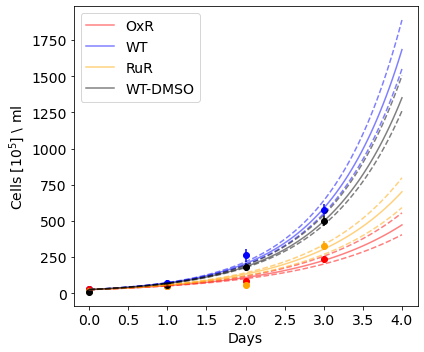

In [1]:
# Import the general functions for metabolic modelling
%run 'general_functions.ipynb'
# Import the results from the growth rate analysis
%run 'growth_rate_analysis.ipynb'

In [2]:
# Load the colorectal cancer model from Uhlen et al. 2017
model = cobra.io.read_sbml_model("../Models/Colon_Combined.xml")
print(len(model.reactions))
print(len(model.metabolites))
model.solver = "gurobi"

# Turn off D-lactate
r = model.reactions.get_by_id("HMR_9136")
r.lower_bound = 0.0
r.upper_bound = 0.0

# Apply the biomass constraints
model.objective = "HCC_biomass"
model.objective_direction = "maximize"
solution = model.optimize()
print(solution)

No objective coefficients in model. Unclear what should be optimized


6716
6479
<Solution 1000.000 at 0x7fe6ec0c72d0>


In [3]:
# Import metabolite constraints 
exodata = pd.read_csv("../Data/metabolites_nM_timeSeriesAnnotated.csv") 

# Get TCA cycle intermediates and create export reactions from the cytosol
# Add reactions to the existing HCT116 model 
TCA_export = exodata.columns[np.where('TCA' == exodata.loc[0])[0]]
for m in TCA_export:
    # Get corresponding metabolite in the cytosol
    met = [i for i in model.metabolites if i.name==m]
    met_c = [m for m in met if m.id[-1]=="c"][0]
    # Create an export reaction for that metbolite
    reaction = cobra.Reaction('HMR_{}x'.format(met_c.id[:-1]))
    reaction.name = "{} Exchange".format(met_c.id)
    reaction.subsystem = "[array(['Exchange/demand reactions'], dtype='<U25')]"
    reaction.lower_bound = -1000.
    reaction.upper_bound = 0.  
    # Add metabolite to the reaction
    reaction.add_metabolites({met_c: +1.0})
    # Add reaction to the model 
    model.add_reactions([reaction])
    
# Save the updated model 
cobra.io.write_sbml_model(model,"../Models/Colon_Combined_updated.xml")

In [4]:
# Transfer the subsystems from the Robinson et al. 2020 model 
subsystem_transfer(model)

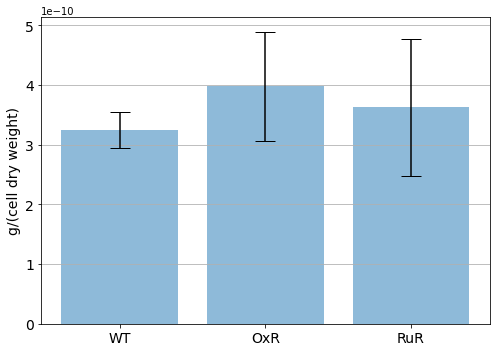

In [2]:
# Dry weight comparison 
growth_data = pd.read_csv('../Data/DryWeight.csv')
fs=14

WT_dat = growth_data.loc[growth_data['Condition'] == "WT"]['DryWeight']
OxR_dat = growth_data.loc[growth_data['Condition'] == "OxR"]['DryWeight']
RuR_dat = growth_data.loc[growth_data['Condition'] == "RuR"]['DryWeight']

cell_types = ['WT','OxR','RuR']
x_pos = np.arange(len(cell_types))
averages = [np.mean(WT_dat), np.mean(OxR_dat), np.mean(RuR_dat)]
error = [np.std(WT_dat)/np.sqrt(len(WT_dat)), np.std(OxR_dat)/np.sqrt(len(OxR_dat)), np.std(RuR_dat)/np.sqrt(len(RuR_dat))]

fig, ax = plt.subplots(figsize=(7,5))
ax.bar(x_pos, averages, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('g/(cell dry weight)',fontsize=fs)
ax.set_xticks(x_pos)
ax.set_xticklabels(cell_types,fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('../Figures/CellDryWeight.svg')
plt.show()

In [5]:
# Get metabolites which are in the model 
metabos = list(exodata.columns[np.where('X' != exodata.loc[0][:-2])[0]])
outliers = ['citrate','homoserine','succinate']
for out in outliers:
    metabos.pop(metabos.index(out))
    
# Iterate through the 4 different model instances
conditions = ["WT","OxR","WT+DMSO","RuR+DMSO"]
times = [24,48,72] 
conv = 1e-6 # convert from nanomole to minimole
DW = [2.94e-10,3.35e-10,2.94e-10,2.31e-10] #dry weight measurements 
RSD_DW = [0.13,0.61,0.13,0.08] #use this to calculate the propagated error 
error_loss = [0.05,0.1,0.15]
glns = [-0.5,-0.8,-0.48,-0.57]

exchange_dict = {"WT":{},"OxR":{},"WT+DMSO":{},"RuR+DMSO":{}}
for met in metabos:
    for gr_mean,dw,condition,gln in zip(growth_rates_mean,DW,conditions,glns):
        exchange = []
        # Calculate the exchange rate for that metabolites 
        initial_concentration = np.mean(get_concentrations(exodata,condition,0.0))*conv
        for time,error in zip(times,error_loss): 
            concentration = np.mean(get_concentrations(exodata,condition,time))*conv
            if met == "glutamine":
                q = exchange_rate_adj(initial_concentration,concentration,gr_mean,time,k=0.0027,DW=dw)
            else:
                q = exchange_rate(initial_concentration,concentration,gr_mean,time,DW=dw)
            exchange.append(q)
        RSD = np.std(exchange)/np.mean(exchange)
        if met == "glutamine":
            upper = float(round(gln + RSD*max(exchange),5))
            lower = float(round(gln - RSD*max(exchange),5))
        else:
            upper = float(round(np.mean(exchange) + RSD*np.mean(exchange),5))
            lower = float(round(np.mean(exchange) - RSD*np.mean(exchange),5))
        exchange_dict[condition][met] = [lower,upper]
#         print("{}: {}".format(condition,[lower,upper]))

/home/users/hherrmann/envs/guropy/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/users/hherrmann/envs/guropy/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


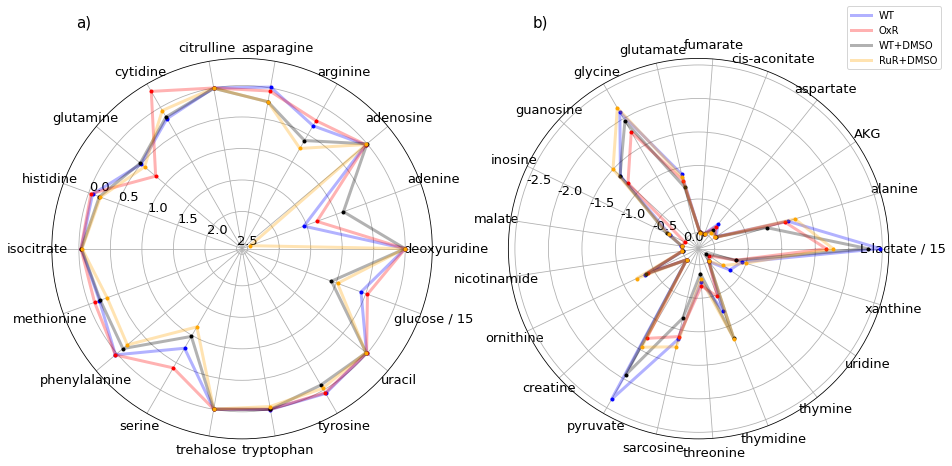

In [6]:
# Split exchange metabolites into uptakes and excretions for plotting
uptake = [met for met in metabos if (exchange_dict["RuR+DMSO"][met][0]+exchange_dict["RuR+DMSO"][met][1])/2 <= 0]
excretion = [met for met in metabos if (exchange_dict["RuR+DMSO"][met][0]+exchange_dict["RuR+DMSO"][met][1])/2 > 0]

cutoff = 5
fig, (ax1,ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True),figsize=(15, 8))
cols = ["blue","red","black","orange"]
fs=13

for ax,mets in zip([ax1,ax2],[uptake,excretion]):
    thetas = np.linspace(0,2*np.pi,len(mets)+1) 
    for condition,col in zip(conditions,cols):
        line = []
        names = []
        for met,theta in zip(mets,thetas):
            val = exchange_dict[condition][met]
            val = (val[0] + val[1])/2
            if abs(val)>cutoff:
                val=val/15
                names.append("{} / 15".format(met))
            else:
                names.append(met)
            ax.plot(theta,val,".",color=col)
            line.append(val)
        line.append(line[0])
        ax.plot(thetas,line,"-",color=col,alpha=0.3,linewidth=3,label=condition)
    ax.set_rlabel_position(160)
    ax.tick_params(labelsize=fs)   
    ax.set_xticks(thetas[:-1])
    ax.set_xticklabels(names,fontsize=fs)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
ax1.text(-180, 1.8, "a)", fontsize=fs+2)
ax1.set_yticks([0.0,-0.5,-1.0,-1.5,-2.0,-2.5])
ax1.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5])
ax2.text(-180, 3.9, "b)", fontsize=fs+2)
ax2.set_yticks([0.0,0.5,1.0,1.5,2.0,2.5])
ax2.set_yticklabels([0.0,-0.5,-1.0,-1.5,-2.0,-2.5])
plt.savefig("../Figures/ExoMetabos.svg")
plt.show()
plt.close()
    # change names for those that were divided, label a and b with text

In [7]:
FA_fetal_cow = ["palmitate","oleate","arachidonate","linoleate","linolenate","stearate","arachidonate"]

In [8]:
for gr_min,gr_max,condition in zip(growth_rates_min,growth_rates_max,conditions):
    # Load the clean model 
    model = cobra.io.read_sbml_model("../Models/Colon_Combined_updated.xml")
    ###########################################################################################
    # Turn off all carbon imports other than those that were experimentally determined
    # and those that come from the blood stream 
    # Allow for individual fatty acid imports rather than the blood stream ratios 
    blood_rxns = ["HMR_9032","HMR_9033"]
    fatty_acid_rxns = []
    for r in model.reactions:
        if len(r.reactants) == 0 or len(r.products) == 0:
            if r.id in ["HCC_biomass"] or r.id in fatty_acid_rxns: 
                pass
            elif r.id in ["HMR_9354","HMR_9383"]:
                # turn off H2O2 and O2- import
                r.upper_bound = 0.0
            elif r.id in blood_rxns:
                met = list(r.metabolites)[0]
                for r_met in met.reactions:
                    if r_met.id not in blood_rxns:
                        # Turn off the original blood pool reactions
                        r_met.lower_bound = 0.0
                        r_met.upper_bound = 0.0
                        # Get all metabolites in blood stream and create 
                        # separate imports for them 
                        for prod in r_met.products:
                            if prod.name in FA_fetal_cow:
                                r_new = cobra.Reaction("{}_FAx".format(prod.id))
                                r_new.add_metabolites({prod:1.0})
                                r_new.lower_bound = 0.0
                                r_new.upper_bound = 1000.0
                                model.add_reactions([r_new])
                                fatty_acid_rxns.append(r_new.id)
            else:
                met = list(r.metabolites)[0]
                if met.name in metabos or r.upper_bound <= 0:
                    # exlude excretion only reactions and 
                    # reactions ofr which the bounds were experimentally determined 
                    pass
                else:
                    # if the import metabolite contains a carbon make the reaction excretion only 
                    if 'C' in met.formula:
                        r.upper_bound = 0.0   
    ###########################################################################################
    # Apply growth rate constraints
    bm_reac = model.reactions.HCC_biomass
    bm_reac.lower_bound = float(gr_min)
    bm_reac.upper_bound = float(gr_max)
    print(bm_reac.bounds)
    for met in metabos:
        # Get the export reaction associated with that metabolite
        model_mets = [m for m in model.metabolites if m.name==met]
        ex_met = [m for m in model_mets if m.id[-1] == "s"]
        if len(ex_met)<1:
            ex_met = [m for m in model_mets if m.id[-1] == "c"]
        ex_reac = [r for r in ex_met[0].reactions if len(r.metabolites) == 1][0]
        # Apply the exchange constraints 
        ex_reac.lower_bound = -exchange_dict[condition][met][0]
        ex_reac.upper_bound = -exchange_dict[condition][met][1]
    test = cobra.flux_analysis.pfba(model)
    ###########################################################################################
    # Remove bile acid reactions 
    subsystem_transfer(model)
    bile_acid_rxns = [r for r in model.reactions if "Bile" in r.subsystem]
    print(len(bile_acid_rxns))
    for r in bile_acid_rxns:
        r.remove_from_model(remove_orphans=True)
    ###########################################################################################
    # Remove blocked reactions from the model all together 
    blocked_rxns = cobra.flux_analysis.variability.find_blocked_reactions(model)
    blocked_rxns = cobra.flux_analysis.variability.find_blocked_reactions(model)
    for rid in blocked_rxns:
        r = model.reactions.get_by_id(rid)
        r.remove_from_model(remove_orphans=True)
    solution = model.optimize()
    print(solution)
    print(len(model.reactions))
    cobra.io.write_sbml_model(model, "../Models/Colon_Combined_exo_woBile_{}.xml".format(condition))
    ###########################################################################################

(10.748326262993917, 11.262402934630341)
114
<Solution 11.262 at 0x7ff70b798a10>
4530
(7.248973695248064, 8.076431846496511)
114
<Solution 8.076 at 0x7ff70b90a890>
4530
(10.208305649112708, 10.670146361573636)
114
<Solution 10.670 at 0x7ff70aeaa050>
4530
(8.240187052582693, 9.018778865797206)
114
<Solution 9.019 at 0x7ff6fdeb6050>
4530
